In [3]:
import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')), " ", tf.config.list_physical_devices('GPU'))

Num GPUs Available:  1   [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [4]:
import os
import cv2

image_data = []

for i in os.listdir("ColorfulOriginal"):
  for j in os.listdir("ColorfulOriginal/" + i):
    img = cv2.imread("ColorfulOriginal/" + i + "/" + j)
    img = cv2.resize(img, (128, 128), interpolation = cv2.INTER_AREA)
    image_data.append(img)

In [5]:
import numpy as np

image_data = np.array(image_data)
image_data.shape

(721, 128, 128, 3)

In [6]:
import random
train_indices = []
for i in range(648):
  x = random.randint(0, 721)
  while(x in train_indices):
    x = random.randint(0, 721)
  train_indices.append(x)
print(len(train_indices))
train_indices = list(set(train_indices))
print(len(train_indices))

648
648


In [7]:
train_data = []
test_data = []

for i in range(721):
  if(i in train_indices):
    train_data.append(image_data[i])
  else:
    test_data.append(image_data[i])

train_data = np.array(train_data)
test_data = np.array(test_data)

train_data.shape, test_data.shape

((647, 128, 128, 3), (74, 128, 128, 3))

In [8]:
import random

def fill(img, h, w):
    img = cv2.resize(img, (h, w), cv2.INTER_CUBIC)
    return img

# HORIZONTAL SHIFT - RANDOM RATIO 0 - 1
def horizontal_shift(img, ratio=0.0):
    ratio = random.uniform(-ratio, ratio)
    h, w = img.shape[:2]
    to_shift = w*ratio
    if ratio > 0:
        img = img[:, :int(w-to_shift), :]
    if ratio < 0:
        img = img[:, int(-1*to_shift):, :]
    img = fill(img, h, w)
    return img

# VERTICAL SHIFT - RANDOM RATIO 0 - 1
def vertical_shift(img, ratio=0.0):
    ratio = random.uniform(-ratio, ratio)
    h, w = img.shape[:2]
    to_shift = h*ratio
    if ratio > 0:
        img = img[:int(h-to_shift), :, :]
    if ratio < 0:
        img = img[int(-1*to_shift):, :, :]
    img = fill(img, h, w)
    return img

# BRIGHTNESS - RANDOM LOW, HIGH 
def brightness(img, low, high):
    value = random.uniform(low, high)
    hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
    hsv = np.array(hsv, dtype = np.float64)
    hsv[:,:,1] = hsv[:,:,1]*value
    hsv[:,:,1][hsv[:,:,1]>255]  = 255
    hsv[:,:,2] = hsv[:,:,2]*value 
    hsv[:,:,2][hsv[:,:,2]>255]  = 255
    hsv = np.array(hsv, dtype = np.uint8)
    img = cv2.cvtColor(hsv, cv2.COLOR_HSV2BGR)
    return img

# ZOOM - RANDOM VALUE 0 - 1
def zoom(img, value):
    value = random.uniform(value, 1)
    h, w = img.shape[:2]
    h_taken = int(value*h)
    w_taken = int(value*w)
    h_start = random.randint(0, h-h_taken)
    w_start = random.randint(0, w-w_taken)
    img = img[h_start:h_start+h_taken, w_start:w_start+w_taken, :]
    img = fill(img, h, w)
    return img

# HORIZONTAL FLIP - RANDOM BOOLEAN
def horizontal_flip(img, flag):
    if flag:
        return cv2.flip(img, 1)
    else:
        return img

# VERTICAL FLIP - RANDOM BOOLEAN
def vertical_flip(img, flag):
    if flag:
        return cv2.flip(img, 0)
    else:
        return img

# ROTATION - RANDOM ANGLE
def rotation(img, angle):
    angle = int(random.uniform(-angle, angle))
    h, w = img.shape[:2]
    M = cv2.getRotationMatrix2D((int(w/2), int(h/2)), angle, 1)
    img = cv2.warpAffine(img, M, (w, h))
    return img
  
# SCALE - RANDOM VALUE 0.6 - 1
def scale(img, value):
  return np.array((value * img), dtype=np.uint8)

In [9]:
augmented_train_data = []
for i in train_data:
  augmented_train_data.append(i)
  for j in range(3):
    augmented_train_data.append(horizontal_shift(i, random.uniform(0, 1)))
    augmented_train_data.append(vertical_shift(i, random.uniform(0, 1)))
    augmented_train_data.append(zoom(i, random.uniform(0, 1)))
    augmented_train_data.append(scale(i, random.uniform(0.6, 1)))

In [10]:
X_train = []
y_train = []
for img in augmented_train_data:
  imageLAB = cv2.cvtColor(img, cv2.COLOR_BGR2LAB)
  L, a, b = cv2.split(imageLAB)
  X_train.append([L])
  y_train.append([a,b])

In [11]:
X_test = []
y_test = []
for img in test_data:
  imageLAB = cv2.cvtColor(img, cv2.COLOR_BGR2LAB)
  L, a, b = cv2.split(imageLAB)
  X_test.append([L])
  y_test.append([a,b])

In [12]:
with tf.device('/GPU:0'):
  X_train = tf.convert_to_tensor(X_train, dtype = np.float32)
  X_test = tf.convert_to_tensor(X_test, dtype = np.float32)
  y_train = tf.convert_to_tensor(y_train, dtype = np.float32)
  y_test = tf.convert_to_tensor(y_test, dtype = np.float32)

X_train.shape, X_test.shape, y_train.shape, y_test.shape

(TensorShape([8411, 1, 128, 128]),
 TensorShape([74, 1, 128, 128]),
 TensorShape([8411, 2, 128, 128]),
 TensorShape([74, 2, 128, 128]))

In [13]:
with tf.device('/GPU:0'):
  y_train = tf.math.subtract(y_train, 128)
  y_test = tf.math.subtract(y_test, 128)

In [14]:
tf.reduce_min(y_train), tf.reduce_max(y_train), tf.reduce_min(y_test), tf.reduce_max(y_test)

(<tf.Tensor: shape=(), dtype=float32, numpy=-71.0>,
 <tf.Tensor: shape=(), dtype=float32, numpy=92.0>,
 <tf.Tensor: shape=(), dtype=float32, numpy=-58.0>,
 <tf.Tensor: shape=(), dtype=float32, numpy=91.0>)

In [15]:
with tf.device('/GPU:0'):
  X_train = tf.divide(X_train, 255)
  X_test = tf.divide(X_test, 255)
  y_train = tf.divide(y_train, 127)
  y_test = tf.divide(y_test, 127)

In [16]:
from tensorflow.keras.models import load_model

with tf.device('/GPU:0'):
  model = load_model("ColorizerModelFinalTanh.h5")
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 1, 128, 128)       65664     
                                                                 
 batch_normalization (BatchN  (None, 1, 128, 128)      512       
 ormalization)                                                   
                                                                 
 conv2d_transpose (Conv2DTra  (None, 1, 256, 256)      33024     
 nspose)                                                         
                                                                 
 batch_normalization_1 (Batc  (None, 1, 256, 256)      1024      
 hNormalization)                                                 
                                                                 
 conv2d_1 (Conv2D)           (None, 1, 128, 128)       131200    
                                                        

In [17]:
import tensorflow as tf

loss = tf.keras.losses.MeanSquaredError(name='mean_squared_error')
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
model.compile(optimizer=optimizer, loss=loss)

In [18]:
with tf.device('/GPU:0'):
  history = model.fit(X_train, y_train, 
                    validation_data=(X_test, y_test), 
                    epochs=25, 
                    batch_size=5,
                    steps_per_epoch=X_train.shape[0]//5,
                    validation_steps=X_test.shape[0]//5,
                    shuffle=True)

Epoch 1/25
1682/1682 [==============================] - 31s 12ms/step - loss: 0.0288 - val_loss: 0.0271
Epoch 2/25
1682/1682 [==============================] - 16s 9ms/step - loss: 0.0255 - val_loss: 0.0239
Epoch 3/25
1682/1682 [==============================] - 14s 9ms/step - loss: 0.0246 - val_loss: 0.0237
Epoch 4/25
1682/1682 [==============================] - 14s 9ms/step - loss: 0.0239 - val_loss: 0.0245
Epoch 5/25
1682/1682 [==============================] - 15s 9ms/step - loss: 0.0229 - val_loss: 0.0292
Epoch 6/25
1682/1682 [==============================] - 15s 9ms/step - loss: 0.0220 - val_loss: 0.0194
Epoch 7/25
1682/1682 [==============================] - 14s 9ms/step - loss: 0.0212 - val_loss: 0.0185
Epoch 8/25
1682/1682 [==============================] - 15s 9ms/step - loss: 0.0207 - val_loss: 0.0253
Epoch 9/25
1682/1682 [==============================] - 15s 9ms/step - loss: 0.0201 - val_loss: 0.0190
Epoch 10/25
1682/1682 [==============================] - 15s 9ms/step - 

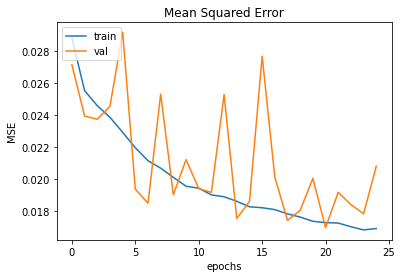

In [19]:
# PLOTTING THE ACCURACY AND VALIDATION ACCURACY VS EPOCHS
from matplotlib import pyplot as plt

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Mean Squared Error')
plt.ylabel('MSE')
plt.xlabel('epochs')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [20]:
model.save("ColorizerModelFinalTranferLearningTanh.h5")

In [22]:
def predict(imgpath, flag):
  img = cv2.imread(imgpath)
  img = cv2.resize(img, (128, 128), interpolation = cv2.INTER_AREA)
  print(img.shape)
  imageLAB = cv2.cvtColor(img, cv2.COLOR_BGR2LAB)
  L, a, b = cv2.split(imageLAB)
  L = L.reshape(1 , 1, 128, 128)
  L = L/255
  pred = model.predict(L)
  a = pred[0][0]
  b = pred[0][1]
  L = L.reshape(128,128)
  L = np.array(L * 255, dtype = np.uint8)
  a = np.array(a * 127, dtype = np.float32)
  b = np.array(b * 127, dtype = np.float32)

  a = a + 128
  b = b + 128

  a = np.array(a, dtype = np.uint8)
  b = np.array(b, dtype = np.uint8)
  imgLAB = cv2.merge([L, a, b])
  image = cv2.cvtColor(imgLAB, cv2.COLOR_LAB2RGB)
  fig, ((ax1,ax2), (ax3, ax4)) = plt.subplots(nrows=2,ncols=2,figsize=(5,8))

  ax1.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
  ax1.set_title("Original Image")
  ax2.imshow(image)
  ax2.set_title("Colorized")
  ax3.imshow(a)
  ax3.set_title("a")
  ax4.imshow(b)
  ax4.set_title("b")
  # cv2.imwrite("img.jpg", cv2.cvtColor(image, cv2.COLOR_RGB2BGR))
  # if(not flag):
  #   image = predict("img.jpg", True)
  return image

(128, 128, 3)
1/1 [==============================] - 0s 408ms/step


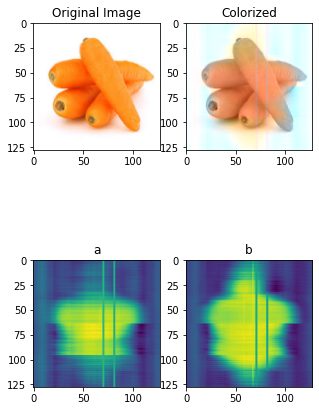

In [23]:
image = predict("ColorfulOriginal/Carrot/carrot11.jpg", False)

In [25]:
from google.colab import files
files.download("ColorizerModelFinalTranferLearningTanh.h5")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>